# Assignment 1b Notebook
This notebook will build off of progress made in Assignment 1a to guide you through the implementation of a basic evolutionary algorithm (EA). As such, you should copy your version of `linear_genotype.py` from the previous assignment repo to the repo for this assignment. If you receive any feedback about the implementation of that algorithm in 1a, please address any problems before you conduct your experiment for 1b. You should also copy over your `data` subdirectory. You may also copy your Assignment 1a notebook over if you wish, but be careful to not overwrite the other files in the repo, as we may have made modifications to them.

Make sure you are in the `EC-env` environment. If you are not, terminate the notebook server, run `conda activate EC-env`, and restart the notebook server.

Please complete this notebook and read *all* text cells. As usual, start by evaluating the next cell (`shift+enter`) to configure the notebook.

In [ ]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['axes.labelsize'] = 8.0
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['savefig.dpi'] = 400.0

import multiprocessing

multiprocessing.set_start_method('fork', force=True)

import os
import statistics
from pathlib import Path
from snake_eyes import read_config
from cutting_stock.fitness_functions import base_fitness_function
from cutting_stock.visualizer import visualize
from stock_population_evaluation import base_population_evaluation
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from selection import *
from log_analyzer import *
from histogram import HistogramMaker
from stats import run_stats

print('The first cell has been executed!')

## Evolutionary Algorithm
The algorithms you will be implementing in this course are black-box search algorithms (BBSAs). Black-box refers to the idea that these algorithms use no problem-specific knowledge in order to search for solutions. These algorithms are often described as using a "generate-and-test" methodology, as a BBSA uses the scores observed from previous solutions to guide its search. In many real-world optimization problems, similar solutions often have similar scores. Thus, by iteratively generating new solutions that are similar to the best solutions seen so far, the algorithm can (hopefully!) find even better solutions. EAs fall into this category of algorithm.

The following diagram depicts the flow of a standard EA:

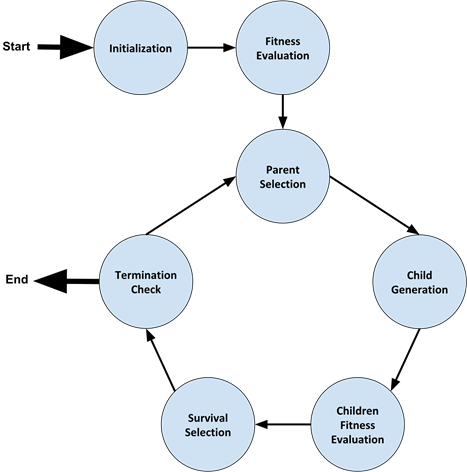

There are many different ways to implement an EA, but in this class we're providing you with a partially-complete framework that demonstrates a modular way to structure code and maximize code re-use throughout the assignments. This means you can gain experience with a codebase similar to what we use in research *and* it means we can just give you code for some of the more mundane and unimportant parts of an EA. Namely, we can give you a configuration parser we use in research. You already used it in Assignment 1a, but we deferred explanation until now.

### The snake_eyes Configuration Parser
The [snake_eyes configuration parser](https://github.com/DeaconSeals/snake_eyes) was developed for research in our lab and is specifically designed for frameworks like the one you'll be working with. The GitHub repo has more general-purpose documentation for using this configuration parser if you're interested in reading more, but the short version is that it takes a configuration file and converts it into a nested dictionary containing the sections and key-value pairs from your configuration file. That's only somewhat different than the [built-in Python configuration parser](https://docs.python.org/3/library/configparser.html) (which [snake_eyes](https://github.com/DeaconSeals/snake_eyes) is built on top of). The most valuable part of [snake_eyes](https://github.com/DeaconSeals/snake_eyes) is that it performs interpolation to determine types and dynamically execute expressions during parsing. This lets us do things like reference constants, functions, and even pass arguments for those functions all from within the configuration file!

This approach might seem a bit quirky, but it can drastically reduce the amount of code refactoring required to add new functionality and we're giving you an example configuration file to show off how to use it. Note that when you call `read_config`, you should pass it three parameters. The first is the path to the config, while the other two parameters should be calls to `globals()` and `locals()`, in that order. The following cell will parse our 1b configuration file and show you its contents:

In [ ]:
# Note the calls to globals() and locals()
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())

# The config is stored as a dictionary of dictionaries
# Note the DEFAULT header; this will not be used in our course, and is an artifact of Python's config parser
print('These are the [header] names for the config:')
for key in config.keys():
    print(key)
print()

# Access the contents of a [header] by using it as a key
print('These are the values within the problem header:')
print(config['problem'])
print()

# Access the individual variables similarly
print('This is the value of the bounds variable:')
print(config['problem']['bounds'])

del config

### Aside: Keyword Parameter Unpacking
Dictionary unpacking is an intermediate-level Python technique that we'll make extensive use of throughout the course. It allows you to effortlessly pass any parameters that are required by a function without actually listing the variables in the callsite code. This is the primary way you will utilize the config.

Unpacking a dictionary into a function call sends all the key-value pairs to the function as if they were passed as keywords (as in `function(key1=value1, key2=value2, ...)`). We couple this with function definitions that accept any and all keyword arguments. If a function needed two parameters, `arg1` and `arg2`, it could be written `def function(arg1, arg2, **kwargs)`. Then, inside the function, any passed keyword arguments other than `arg1` and `arg2` are stored in the `kwargs` dictionary.

Execute the following cell for a brief demo of how to accept arbitrary named arguments and unpack named arguments from a dictionary. If you find yourself confused by this example or just want to read more, see [here](https://realpython.com/python-kwargs-and-args/).

In [ ]:
def outer_example_function(arg1, arg2, **kwargs):
    print('Outer function takes arg1 and arg2:')
    print('\targ1:', arg1)
    print('\targ2:', arg2)
    print('\tkwargs:', kwargs)
    print()
    inner_example_function(**kwargs)

def inner_example_function(arg3, arg4, arg5, **kwargs):
    print('Inner function takes arg3, arg4, and arg5:')
    print('\targ3:', arg3)
    print('\targ4:', arg4)
    print('\targ5:', arg5)
    print('\tkwargs:', kwargs)

parameter_dict = {'arg1': 'first',
                  'arg2': 'second',
                  'arg3': 'third',
                  'arg4': 'fourth',
                  'arg5': 'fifth',
                  'arg6': 'sixth'}
print('Parameters:', parameter_dict)
print()
outer_example_function(**parameter_dict)

del parameter_dict, outer_example_function, inner_example_function

In order to make sure your code is ready for this assignment and works as intended, we'll carry out a brief (and not very thorough) test of your `LinearGenotype.random_initialization` implementation in the following cell, using the techniques we just showed off. We'll use parameters from our configuration file to both test `random_initialization` and evaluate the fitness of the generated solution. You saw this in Assignment 1a, but you may not have understood what exactly was happening under the hood until now.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
test_solution = LinearGenotype()
test_solution.random_initialization(**config['problem'])

print('The random_initialization function did something?', test_solution.genes is not None)
print('Was the solution the right length?', len(test_solution.genes) == len(config['problem']['shapes']))

output = base_fitness_function(test_solution.genes, **config['problem'])
test_solution.fitness = output['fitness']

print(f'The solution has fitness {test_solution.fitness}, and looks like this:')
visualize(test_solution.genes, **config['problem'])

del config, test_solution, output

### Initialization
Recall that the random search algorithm implemented in Assignment 1a is functionally equivalent to the initialization step performed at the beginning of an EA. While there are alternative initialization methods that seed the initial population with known-good solutions or even perform a preliminary search, randomly generating initial solutions is the most common choice in practice.

Those of you who have looked at the other member functions of the `LinearGenotype` class may have noticed the `initialization` class method. In Assignment Series 2 you will need to write your own population initialization function, but for Assignment Series 1 we are providing you with the function to do this. The code for `LinearGenotype.initialization` is as follows:

```python
class LinearGenotype():
    ...
    @classmethod
    def initialization(cls, mu, *args, **kwargs):
        population = [cls() for _ in range(mu)]
        for i in range(len(population)):
            population[i].random_initialization(*args, **kwargs)
        return population
```

This is really just a convenient shorthand for creating and randomly initializing a list of multiple `LinearGenotype`s in one line. As an example, the following cell will use your `LinearGenotype.random_initialization` method to create a population of 10 individuals.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])

print('Population size:', len(example_population))
print('Number of uninitialized individuals:', [i.genes is None for i in example_population].count(True))
length = len(config['problem']['shapes'])
print('Number of individuals with correct length:', [len(i.genes) for i in example_population].count(length))

del config, example_population, length

### Fitness Evaluation
Now that you have a function for *initializing* an entire population, the next step is to implement a function for *evaluating* an entire population. Implement the `base_population_evaluation` function in `stock_population_evaluation.py` to evaluate all individuals in an input population. Simply call `base_fitness_function` on each individual's `genes` (along with `**kwargs`), and assign the `fitness` member variable as demonstrated two code cells ago.

We'll test your implementation in the next cell. We will initialize 25,000 individuals with `LinearGenotype.initialization`, evaluate them with `base_population_evaluation`, print some information about their fitnesses, and show off the best solution. We'll also use a `HistogramMaker` to visualize the distribution of their fitnesses.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
hist = HistogramMaker(**config['problem'])
example_population = LinearGenotype.initialization(25_000, **config['problem'])

# Calling your function to test things out
# Note the way the config is unpacked
base_population_evaluation(example_population, **config['problem'])

fitnesses = [individual.fitness for individual in example_population]

if None in fitnesses:
    print('Some individuals had unassigned fitness! Fix your code and run this cell again.')
else:
    print('Mean fitness of population:', statistics.mean(fitnesses))
    print('Best fitness in population:', max(fitnesses))
    best_individual = max(example_population, key=lambda individual:individual.fitness)
    
    print('The highest-fitness individual looks like this:')
    visualize(best_individual.genes, **config['problem'])

    for fit in fitnesses:
        hist.add(fit)
    print('The fitnesses were distributed like this:')
    hist.get_plot('Example Fitness Distribution').show()
    
    del config, hist, example_population, fitnesses, best_individual

### Aside: Sampling With and Without Replacement
Stochastically selecting samples from a population is a very common practice in many fields of study, and a critical component of EC implementations. There are two fundamental ways to conduct this sampling: with replacement and without replacement. The names are often explained by an example such as drawing cards from a deck. If you draw a card, you have a choice of whether or not to put it back in the deck before you draw again. If you put it back in the deck, you are replacing it, so you are sampling *with replacement*. If you don't put the card back, you are not replacing it, so you are sampling *without replacement*.

In the context of EC, sampling *with* replacement means the same individual can be selected any number of times. On the other hand, sampling *without* replacement means each individual is selected exactly once or not at all. In general, parent selection is with replacement, while survival selection is without replacement. An individual can have many children in one generation, but logically can't be selected to survive multiple times in one generation -- it either survives, or dies.

**Note**: the textbook regrettably sometimes uses *replacement* as a synonym for *survival selection*, particularly on pages 87-89. To avoid confusion, we will not adopt this vocabulary and strongly discourage its use.

### Parent Selection
After evaluating the initial population, the evolutionary cycle begins with parent selection. You will now implement the parent selection methods in the `selection.py` file. This file also contains survival selection functions that we will implement later. In general, parent selection algorithms can select the same individual multiple times (i.e., an individual can reproduce multiple times in a generation). Selection functions take as input a population as well as `n`, the number of individuals that should be selected from that population. Individual functions may also have additional parameters, which we will explain as they come up.

To start off, implement `uniform_random_selection` in `selection.py`. This function should select `n` individuals uniform randomly (i.e., with equal probability), with replacement, out of all individuals in the input population.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

num_parents = 20
parents = uniform_random_selection(example_population, num_parents)

print('The function did something?', parents is not None)
print('The correct number of parents were selected?', len(parents) == num_parents)

del config, example_population, num_parents, parents

Now implement `k_tournament_with_replacement` in `selection.py`. This algorithm samples `k` individuals from the population then selects the most fit of these as the winner, and repeats this process `n` times. That is, you should conduct `n` different independent tournaments, each of size `k`. **The contestants within each tournament are sampled without replacement**, meaning the `k` individuals in any given tournament are all unique. However, **the algorithm overall samples with replacement**, meaning an individual can win multiple tournaments. The book suggests that the `k` individuals in a tournament may be sampled with or without replacement, but we require it to be *without* replacement.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

num_parents = 20
parents = k_tournament_with_replacement(example_population, num_parents, k=2)

print('The function did something?', parents is not None)
print('The correct number of parents were selected?', len(parents) == num_parents)

del config, example_population, num_parents, parents

Finally, implement `fitness_proportionate_selection` in `selection.py` to select `n` individuals with a probability proportional to their fitness in the entire population. Again, this is with replacement. In this assignment series, fitness values can sometimes be negative. This means that you can't simply calculate probabilities as each individual's fitness divided by the total population fitness. **If** you have negative fitness within the population, **then** it's necessary to instead calculate selection weights based on fitness, rather than using fitness values directly. There are several methods to overcome this limitation, but our suggested approach is to subtract the minimum fitness in the population from all fitness values to form nonnegative weights that may be used instead. When doing this, make sure you are using local variables instead of changing the actual fitness value members!

**Note:** To be clear, only calculate scaled selection weights **if** negative fitness exists within the population. When doing this, look out for the edge case where all fitnesses are negative and equal (hint: selection probabilities in this case are uniform).

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

num_parents = 20
parents = fitness_proportionate_selection(example_population, num_parents)

print('The function did something?', parents is not None)
print('The correct number of parents were selected?', len(parents) == num_parents)

del config, example_population, num_parents, parents

### Recombination
Once parents are selected, their genetic information is recombined to produce a new individual. Fixed-length linear genotypes have several performant and simple recombination methods. These will be implemented in the `LinearGenotype.recombine` method found in `linear_genotype.py`. You will implement uniform recombination and 1-point crossover (Section **4.2.2** in the textbook), treating the placement for each shape as an atomic allele (i.e., recombination should take the x, y, and rotation values for a shape all together).

Note that you can add any necessary arguments to the `recombination_kwargs` section of `configs/1b_green_config.txt`. `LinearGenotype.recombine` takes as input a mate, a method, and any arguments you require, initializes a `child` object of the type `LinearGenotype`, recombines the `genes` member variables of `self` and `mate` to populate the `genes` member variable of `child`, and then returns the `child` object. It is **strongly** advised that you use the `deepcopy` function from the `copy` module when copying alleles from parent to child. Unless you are an experienced Python developer, it is very easy for naïve shallow copies to cause *incredibly* frustrating and subtle bugs. While deepcopies are computationally expensive and often unnecessary, they are the simplest option for preventing these issues for less-experienced developers. The following cell will reload the config to retrieve any new parameters you've added and test your implementation.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
parents = LinearGenotype.initialization(2, **config['problem'])
parent0 = parents[0]
parent1 = parents[1]

child = parent0.recombine(parent1, **config['recombination_kwargs'])
print('The function did something?', child.genes is not None)
print('The child genes are the right length?', len(child.genes) == len(parent0.genes))

# testing for actual recombination of multiple genes
for i in range(len(parent0.genes)):
    parent0.genes[i] = (1, 1, 1)
    parent1.genes[i] = (2, 2, 2)

child = parent0.recombine(parent1, **config['recombination_kwargs'])
print('The child genes contain information from both parents?', (1, 1, 1) in child.genes and (2, 2, 2) in child.genes)
print('The child genes only contain information from parents?', all([x == (1, 1, 1,) or x == (2, 2, 2) for x in child.genes]))

del config, parents, parent0, parent1, child

### Mutation
Mutation is a method for introducing variance and additional genetic information into the population. In the base EA we're implementing now, mutation has a chance to occur on children just produced from recombination based on a configurable mutation rate. Thus, the mutation rate parameter of an EA controls how often new children are mutated. The `LinearGenotype.mutate` method in `linear_genotype.py` that you're about to implement assumes that the individual (`self`) has already been selected to mutate via an external mechanism. In other words, your `LinearGenotype.mutate` function should nearly always result in a mutation of some kind (i.e., there should be no conditional that tries to prevent a mutation from occurring).

You may implement mutation however you wish, but we require that your implementation is capable of changing all 3 values in an allele (not necessarily all at once), and is capable of producing new values even if they don't already exist in the population (unlike recombination). For inspiration, you may want to look at canonical mutation functions for integer genotypes (reset mutation and creep mutation; see Section **4.3.1** in the textbook). However, keep in mind the valid ranges for each value (the x bounds, y bounds, and 0, 1, 2, or 3 rotations). Your mutation should not produce any values outside of these valid ranges. You should also avoid the somewhat common mistake of having an extremely destructive mutation function; it should only change a relatively small amount of the genes, not act like a new random reinitialization.

Like the recombination function, you can add any necessary parameters to the config's `mutation_kwargs` section. `LinearGenotype.mutate` takes an individual and these parameters as input, and returns a new individual (i.e., you don't modify the calling object). In this case, modify the `copy` object instantiated within the function and return it. Also like recombination, we **strongly** advise you to use `deepcopy`. The following cell will reload the config to retrieve any new parameters you've added and test your implementation. Note that some mutation implementations might rarely not result in a change, if the mutated values are coincidentally the same as the input values (i.e., sampling a new rotation value might only cause a change 3/4 of the time, since there are only four valid values, one of which is the input). We consider such implementations valid, so it's not necessary to pass the second test in this cell 100% of the time, but it should be a solid majority of the time.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())

original = LinearGenotype.initialization(1, **config['problem'])[0]
mutant = original.mutate(**config['mutation_kwargs'])

print('The mutant genes were the right length?', len(original.genes) == len(mutant.genes))

different = False
for i in range(len(original.genes)):
    for j in range(len(original.genes[i])):
        if original.genes[i][j] != mutant.genes[i][j]:
            different = True

print('The mutant was changed?', different)

del config, original, mutant, different

### Child Generation
There are multiple ways to select parents, but the two most common approaches are the following:
 * Select all parents at once to form a "parent pool", then iterate over it and generate children
 * Repeatedly select pairs of parents to generate one child at a time

Both techniques have scenarios where they make more or less sense to use, but **in these assignments you will be using a parent pool**. We have provided you with the code to create a parent pool using the selection algorithms you've implemented. However, it's important to consider and minimize sampling error in your implementation. As a rule of thumb, avoid scenarios where a parent must win a lottery *after* being selected as a parent in order to actually reproduce. That is, don't randomly sample from the pool. You should simply iterate over the pool in pairs.

Now, you must implement the `generate_children` method of the `BaseEvolutionPopulation` class in `BaseEvolution.py`. Note that the member variables of the `BaseEvolutionPopulation` class contain the parent selection function itself in `self.parent_selection`, in addition to member variables with kwargs for parent selection, recombination, and mutation. It also contains `self.num_children`, the number of children to produce ($\lambda$), and `self.mutation_rate`, the probability that each child undergoes mutation. Our implementation uses `num_children` instead of `lambda`, the preferred EC term, because `lambda` is a reserved keyword in Python. However, you should understand that these are synonyms.

Implement `BaseEvolutionPopulation.generate_children` such that it utilizes `self.parent_selection` and all other necessary member variables to generate and return a population of children formed from `self.population`. The following cell will test your implementation. For now, ignore how we're using `example_ea`. We are also temporarily overriding the `mu` and `num_children` values in `1b_green_config.txt`, since large values can make testing this function take as long as a full run of the EA!

In [ ]:
# Setting up the population; you can ignore this section
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
config['ea']['mu'] = 50
config['ea']['num_children'] = 10
config['parent_selection_kwargs']['k'] = 2
example_ea = BaseEvolutionPopulation(**config['ea'], **config)
base_population_evaluation(example_ea.population, **config['problem'])

# Testing your generate_children method
children = example_ea.generate_children()
print('The correct number of children were generated?', len(children) == example_ea.num_children)

del config, example_ea, children

### Survival Selection
Recall from earlier that `selection.py` contained functions for both parent selection and survival selection for you to implement. While parent selection algorithms can generally select the same individual to be a parent multiple times in a given generation (*with replacement*), survival selection must only select unique individuals to survive (*without replacement*). That is to say that no individual in a population should be placed into the surviving population twice and, once selected to survive, an individual must no longer be considered during the same round of survival selection.

We'll start by implementing a classic survival selection method: `truncation`. In the `truncation` survival selection algorithm, the `n` fittest individuals from the input population are selected to survive. Implement the `truncation` function in `selection.py` to behave this way and return the `n` surviving individuals. The next cell will test your implementation.

In [ ]:
num_survivors = 2

config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

survivors = truncation(example_population, num_survivors)
print('The correct number of survivors were selected?', len(survivors) == num_survivors)

del num_survivors, config, example_population, survivors

Now implement the `k_tournament_without_replacement` function in `selection.py`. Like the parent selection version of k-tournament, `k_tournament_without_replacement` takes as input a value `k`, forms tournaments from sampling `k` unique individuals from the input population (*without replacement*), and selects the most fit as the winner of the tournament. Unlike the parent selection version, however, **the winner of each tournament cannot be selected as one of the `k` contestants in future tournaments**. That is, the `k` contestants in each tournament should be individuals that *haven't* previously won a tournament.

The following cell will test your `k_tournament_without_replacement` implementation.

In [ ]:
num_survivors = 2

config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

survivors = k_tournament_without_replacement(example_population, num_survivors, k=2)
print('The correct number of survivors were selected?', len(survivors) == num_survivors)

del num_survivors, config, example_population, survivors

## Unit testing your implementation
Executing the following cell will launch a Bash command to unit test your implementation thus far. This will perform a series of automated tests on the functions you've implemented so far and will attempt to identify any bugs (and save you from later headaches) before you implement your full EA. Note that since your algorithms are highly stochastic, the unit tests have some margin of error. **We recommend running the tests a few times in a row to make sure everything works, but also understand that if any given test fails a small percentage of the time (<10%) it's probably not your algorithm's fault.** You are expected to try to diagnose errors on your own before contacting a TA for assistance. The test results should show you what part of your code might be failing, and what criteria it may be failing to meet. Passing these unit tests is part of your grade -- we will run them, and we expect that every test should pass the majority of the time. Note that some of the unit tests may take a few seconds, since testing stochastic algorithms requires sampling their behavior many times.

A failed assertion is itself generally not helpful (the test's algorithmic implementation is probably not worth the effort to analyze). You should look at the name of the test, the class the test is a part of, and the comment underneath the test's definition. These should point you in the right direction. On the other hand, if the test is failing because of a real error (rather than an assertion), then the stack trace will be very helpful.

In addition, a single bug may cause multiple tests to fail; if you can't understand why one test is failing, you might want to focus on fixing a different test, and see if that fixes several at once.

In [ ]:
!pytest

## Assembling the EA framework
Now that you've implemented all the necessary components, it's time to learn how to use the `BaseEvolutionPopulation` class you'll be using throughout this course. This class can be found in `base_evolution.py` and contains some high-level functions that will use your code to implement the major segments of an EA:
 * Initialization
 * Child generation
 * Survival selection

After initialization, we require you to log three values in a specific way. We've provided the code to do this in the cell below. Aside from this logging after initialization, you will log the same values at the end of each generation, and even more values are logged automatically when you call `BaseEvolutionPopulation`'s member functions. This log is not a recommended format for you to parse algorithmically (i.e., you *must* track data for analysis & plotting separately), but is here to help you (and us!) detect problems in your EA.

We'll start by calling initialization, which is provided for you. Note that we'll begin making extensive use of our config dictionary and the `**kwargs` technique. Note also that we're hardcoding some of the parameters for these examples.

In [ ]:
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
hist = HistogramMaker(**config['problem'])

# Hardcode some values for this example, to make it quicker
config['ea']['mu'] = 50
config['ea']['num_children'] = 10
config['parent_selection_kwargs']['k'] = 3
config['survival_selection_kwargs']['k'] = 3

# Initialize the EA, including an unevaluated population of size mu
example_ea = BaseEvolutionPopulation(**config['ea'], **config)

# Evaluate the initial population
base_population_evaluation(example_ea.population, **config['problem'])

# Add fitnesses to the HistogramMaker
for individual in example_ea.population:
    hist.add(individual.fitness)

# Keep track of evaluation count
example_ea.evaluations = len(example_ea.population)

# Add stats to the log after the initial generation
example_ea.log_base_stats()

# Print statements for tutorialization
print('Population size:', len(example_ea.population))
print('Average fitness of population:', statistics.mean([individual.fitness for individual in example_ea.population]))
print('Best fitness in population:', max([individual.fitness for individual in example_ea.population]))
print('Evaluation count:', example_ea.evaluations)

Now that the population is initialized and evaluated, it's time to make children for the next generation. You should have already implemented the `generate_children` function. In a ($\mu$+$\lambda$)-EA, the children are simply added to the population alongside the parents:

In [ ]:
# Generate children
children = example_ea.generate_children()

# Evaluate children
base_population_evaluation(children, **config['problem'])

# Add fitnesses to the HistogramMaker
# Note how we only add the children!
# The adults have already been added; do not count fitnesses twice!
for child in children:
    hist.add(child.fitness)

# Update evaluation count
example_ea.evaluations += len(children)

# Add evaluated children to the adult population
example_ea.population += children

# Print statements for tutorialization
print('Number of children made:', len(children))
print('Average fitness of children:', statistics.mean([individual.fitness for individual in children]))
print('Best fitness of children:', max([individual.fitness for individual in children]))
print('New population size:', len(example_ea.population))
print('Evaluation count:', example_ea.evaluations)

We will now call the provided `BaseEvolutionPopulation.survival` method to perform survival selection using the algorithms you've implemented, reducing the population back to size $\mu$:

In [ ]:
# Perform survival selection
example_ea.survival()

# Add stats to the log after each generation's survival selection
example_ea.log_base_stats()

# Print statements for tutorialization
print('New population size:', len(example_ea.population))
print('Average fitness of survivors:', statistics.mean([individual.fitness for individual in example_ea.population]))
print('Best fitness of survivors:', max([individual.fitness for individual in example_ea.population]))

In [ ]:
# execute this cell to clean up variables left over from the previous cells
del config, hist, example_ea, children

Now combine everything we just showed you to write a function that performs one run of a ($\mu$+$\lambda$)-EA. You should initialize a `BaseEvolutionPopulation`, evaluate the population, then have a generational loop that creates children, evaluates them, and performs survival selection. The loop should continue until you have conducted `num_evaluations` total evaluations.

The way we have done things in the example cells was very deliberate. **You MUST call the EA's `log_base_stats()` method and add fitnesses to the `HistogramMaker` as we have shown above.** Except for the absence of a generational loop, the above code contains basically everything you need to make an EA. In addition to the unit tests, we also have code that attempts to validate your EA's overall behavior based on values that are logged over the course of your run. While it is by no means proof of (in)correctness, it can bring atypical behavior to your attention. The code we've given you in the following cell calls this analysis function for you after each run.

**In addition,** you will need to record the mean and max fitness in the adult population after initialization and every generation after survival selection. This will be used to generate an evals-vs-fitness plot later in the assignment. It's up to you to determine how to collect this data.

To reiterate, just like in Assignment 1a, there are a few things you need to do in addition to simply implementing a search algorithm:

1. (Same as 1a) Call `hist.add(solution.fitness)` once on every solution
2. (Same as 1a) Return the highest-fitness `LinearGenotype` as `best_solution`
    * Note this is the **GLOBAL** best solution: this is the best solution your algorithm has ever generated, and not just the best from the final generation
3. (**NEW**) Call your EA's `log_base_stats()` method after each generation (including the initial population), as shown in the example cells
4. (**NEW**) Update your EA's `evaluations` member every time you evaluate individuals, as shown in the example cells
    * Make sure to do this before the call to `log_base_stats()`
5. (**NEW**) Return the mean and max fitness in the adult population at the end of each generation (including the initial population) as `mean_fit_per_gen` and `max_fit_per_gen`
    * Note this is **LOCAL** mean and max fitness: calculate this using only the current adult population at the end of each generation
6. (**NEW**) Return the cumulative evaluation count at the end of each generation (including the initial population) as `evaluation_counts`
    * That is, `evaluation_counts[i] == ea.evaluations` at the end of generation `i`

In [ ]:
from math import inf

def evolutionary_algorithm_run(num_evaluations, config):
    # Initialize a HistogramMaker
    hist = HistogramMaker(**config['problem'])

    # Starting at -inf is a good way to keep track of the best fitness
    best_fitness = -inf

    # Assign your best LinearGenotype to this variable
    best_solution = None

    # Assign the mean fitness at each generation to this variable
    # We recommend using a list
    mean_fit_per_gen = None

    # Assign the max fitness at each generation to this variable
    # We recommend using a list
    max_fit_per_gen = None

    # Assign the evaluation count at each generation to this variable
    # We recommend using a list
    evaluation_counts = None
    
    # Initialize the EA, including an unevaluated population of size mu
    ea = BaseEvolutionPopulation(**config['ea'], **config)


    # Implement your EA here using the functionality we demonstrated in the previous cells
    # Using the above ea variable, evaluate the initial population,
    # continually run generations until you have evaluated num_evaluations solutions in total,
    # and collect data as required

    

    # This will print outputs if it looks like anything has gone wrong.
    analyze_base_log(ea.log, num_evaluations)

    return best_solution, mean_fit_per_gen, max_fit_per_gen, evaluation_counts, hist, ea.log

Now run the next cell to test your function. This may take a minute or two to run. **If you ever change the function in the previous cell, make sure to execute that cell again so the changes get loaded by the interpreter!** Otherwise, the changes won't take effect in other cells.

In [ ]:
num_evaluations = 100_000
config = read_config('configs/1b/easy_green_config.txt', globals(), locals())

# Testing one run of your EA (don't worry if the results are very poor, you'll improve it later on!)
(
    best_solution,
    mean_fit_per_gen,
    max_fit_per_gen,
    evaluation_counts,
    hist,
    log
) = evolutionary_algorithm_run(num_evaluations, config)

# Save the logged values to a file for you to view
with open('example_log.txt', 'w') as f:
    f.write(''.join(line + '\n' for line in log))

print('Best solution fitness:', best_solution.fitness)
print('Best solution looks like:')
visualize(best_solution.genes, **config['problem'])

print('Histogram:')
hist.get_plot('Distribution of Fitnesses Over 1 Run').show()

print('Mean fitnesses per generation:')
print(mean_fit_per_gen)
print('Max fitnesses per generation:')
print(max_fit_per_gen)
print('Evaluation counts per generation:')
print(evaluation_counts)

del config, num_evaluations, hist, log, best_solution, mean_fit_per_gen, max_fit_per_gen, evaluation_counts

If your results are dissapointingly bad, don't worry; that's expected. You'll need to tune your EA later in order to obtain decent results, and we will walk you through this process later in this notebook.

Did the log analyzer print any warnings about your algorithm at the start of the previous cell's output? If it did, this likely represents a bug in your implementation. Read the warning carefully, and try to figure out what went wrong before proceeding. Note we wrote your EA's log to `example_log.txt`, which may help in diagnosing errors.

## Experiment
Just like in Assignment 1a, now that you've implemented a function for a single run, it's time to implement a function for a multi-run experiment. The data you need to collect is fairly similar to some of the data you collected in 1a:

1. (Same as 1a) The highest fitness value encountered in each run (one number per run) as `best_per_run`
2. (Same as 1a) The highest-fitness `LinearGenotype` found by any of the runs as `best_solution`
3. (Same as 1a) The `HistogramMaker` representing the data collected from the runs (**this is already done for you!**)
4. (**NEW**) The mean and max fitness in the adult population at each generation (including the initial population) in each run as `mean_per_gen_per_run` and `max_per_gen_per_run`
    * This is just stacking the generational data from each run as 2-dimensional data (see comments in the below function for examples)
5. (**NEW**) The number of evaluations at the end of each generation (including the initial population) as `evaluation_counts`
    * Since this should be the same for every run in an experiment, we only need a 1-dimensional data structure (you can just use the `evaluation_counts` returned from a single run)

Now, implement code for a multi-run experiment in the following cell. **As a reminder, if you get pickle encoding errors, you need to re-execute the following cell.** And again, if you run into issues due to low RAM, you can manually lower the number of parallel runs by passing the `processes` parameter to `multiprocessing.Pool()`. Note this can begin happening on this assignment even if you had very low RAM usage in Assignment 1a, so watch out!

In [ ]:
from stock_population_evaluation import base_population_evaluation
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from selection import *

# Like in Assignment 1a, we use this function to avoid pickling errors.
# It will call your run function, serialize the best solution,
# and return the string and its fitness value instead of the entire LinearGenotype.
def multiprocess_helper(num_evaluations, config):
    (
        best_solution,
        mean_fit_per_gen,
        max_fit_per_gen,
        evaluation_counts,
        hist,
        log
    ) = evolutionary_algorithm_run(num_evaluations, config)
    return best_solution.serialize(), best_solution.fitness, \
           mean_fit_per_gen, max_fit_per_gen, \
           evaluation_counts, hist, log


def evolutionary_algorithm_experiment(num_runs, num_evaluations, config):
    # We handle this for you; don't worry about the histograms here
    hist_per_run = []

    # We handle this for you; don't worry about the logs here
    logs = []

    # Assign the highest fitness value seen in each run to this variable
    # i.e., a list/tuple of num_runs numbers
    best_per_run = None

    # Assign your best LinearGenotype to this variable
    # It should be the highest-fitness solution seen across all runs
    best_solution = None

    # Use these to store the mean fitness and max fitness at each generation from each run
    # This should be a 2-dimensional data structure, for example:
    # mean_per_gen_per_run[r] is the mean_fit_per_gen returned from run r
    # Therefore:
    # mean_per_gen_per_run[r][g] is the mean fitness from run r at generation g
    mean_per_gen_per_run = None
    max_per_gen_per_run = None

    # Assign the evaluation counts at the end of each generation to this variable
    # Since this should be the same for every run in an experiment, you can just
    # return the evaluation_counts from one of the runs
    evaluation_counts = None

    

    # This executes your runs in parallel, using the multiprocess_helper function
    # IMPORTANT: If you are running out of RAM, as mentioned in the above text,
    # you can pass 'processes' keyword argument to multiprocessing.Pool() here
    with multiprocessing.Pool() as pool:
        args = [(num_evaluations, config)] * num_runs
        run_results = list(pool.starmap(multiprocess_helper, args))

    # Iterate over the completed runs' results
    for i in range(num_runs):
        # This gets the data from run i,
        # deserializes its best solution as run_best_solution,
        # collects the histogram (don't worry about the histogram),
        # and collects the log (don't worry about the log)
        (
            run_serialization,
            run_best_fitness,
            mean_fit_per_gen,
            max_fit_per_gen,
            run_evaluation_counts,
            hist,
            log
        ) = run_results[i]
        run_best_solution = LinearGenotype()
        run_best_solution.deserialize(run_serialization)
        run_best_solution.fitness = run_best_fitness
        hist_per_run.append(hist)
        logs.append(log)
        
        # TODO: Use run_best_solution, mean_fit_per_gen,
        #       max_fit_per_gen, and run_evaluation_counts
        #       to collect data in the variables described
        #       at the start of this function.
        
        
    
    # Merge the histograms into one single histogram
    merged_hist = HistogramMaker.merge(hist_per_run)

    return best_per_run, best_solution, mean_per_gen_per_run, max_per_gen_per_run, evaluation_counts, merged_hist, logs

Let's run a quick test in the next cell to make sure everything works, before we embark on a full experiment. As a reminder, **if you change the previous cell, make sure to re-run that cell to save the changes to your function!** We'll do 3 runs:

In [ ]:
example_num_runs = 3
example_num_evaluations = 100_000
easy_config = read_config('configs/1b/easy_green_config.txt', globals(), locals())

(
    example_best_per_run,
    example_best_solution,
    example_mean_per_gen_per_run,
    example_max_per_gen_per_run,
    example_evaluation_counts,
    example_hist,
    example_logs
) = evolutionary_algorithm_experiment(example_num_runs,
                                      example_num_evaluations,
                                      easy_config)

print('Correct number of best fitnesses?', example_num_runs == len(example_best_per_run))
print('Correct number of runs in mean per gen data?', example_num_runs == len(example_mean_per_gen_per_run))
print('Correct number of runs in best per gen data?', example_num_runs == len(example_max_per_gen_per_run))

print('Best fitness per run:', example_best_per_run)
print('Best solution fitness:', example_best_solution.fitness)
print('Best solution looks like:')
visualize(example_best_solution.genes, **easy_config['problem'])

print('Histogram:')
example_hist_plot = example_hist.get_plot('Example EA Experiment (3 Runs)')
example_hist_plot.show()

print('Mean fitnesses per generation per run:')
print(example_mean_per_gen_per_run)
print('Max fitnesses per generation per run:')
print(example_max_per_gen_per_run)
print('Evaluation counts per generation:')
print(example_evaluation_counts)

Just like in Assignment 1a, we have provided a function to save your experimental data for you:

In [ ]:
def save_data(best_per_run, best_solution, mean_data, max_data, eval_counts, hist, logs, subdir, config):
    subdir.mkdir(parents=True, exist_ok=True)

    with open(subdir / 'best_per_run.txt', 'w') as f:
        for result in best_per_run:
            f.write(str(result) + '\n')

    with open(subdir / 'best_solution.txt', 'w') as f:
        f.write(best_solution.serialize())

    visualize(best_solution.genes, path=subdir / 'best_solution.png', **config['problem'])

    with open(subdir / 'mean_per_gen_per_run.txt', 'w') as f:
        f.write(str(mean_data))

    with open(subdir / 'max_per_gen_per_run.txt', 'w') as f:
        f.write(str(max_data))

    with open(subdir / 'evaluation_counts.txt', 'w') as f:
        f.write(str(eval_counts))

    hist.save_to_file(subdir / 'histogram.txt')

    logdir = subdir / 'logs'
    logdir.mkdir(exist_ok=True)
    for i in range(len(logs)):
        with (logdir / f'{i}.txt').open('w') as f:
            f.write(''.join(line + '\n' for line in logs[i]))

    print('Data saved to', subdir)

Run the following cell and navigate to `data/1b/example/` to inspect the results and make sure everything looks correct.

In [ ]:
save_data(example_best_per_run,
          example_best_solution,
          example_mean_per_gen_per_run,
          example_max_per_gen_per_run,
          example_evaluation_counts,
          example_hist,
          example_logs,
          Path('./data/1b/example/'),
          easy_config)
example_hist_plot.savefig('data/1b/example/histogram.png')

### Evals-vs-fitness Plot
Now we will write a function to generate an evals-vs-fitness plot averaged across the runs in an experiment. That is, for each run, you should have recorded a mean and max fitness at each generation. For each generation, calculate the average mean fitness and average max fitness across all runs at that generation. For example, the average mean fitness for generation `0` is the average of `mean_per_gen_per_run[run][0]` across all runs. Likewise, the average mean fitness for generation `x` is the average of `mean_per_gen_per_run[run][x]` across all runs. The average maximum fitness values are calculated similarly.

We will use this data to plot the *number of evaluations* (not generations) versus the mean and maximum fitness averaged over all runs in an experiment. That is, the x-values will be pulled from the `evaluation_counts` your experiment function returned. You will need to calculate and set the y values appropriately. Here's what a correct evals-vs-fitness plot looks like:

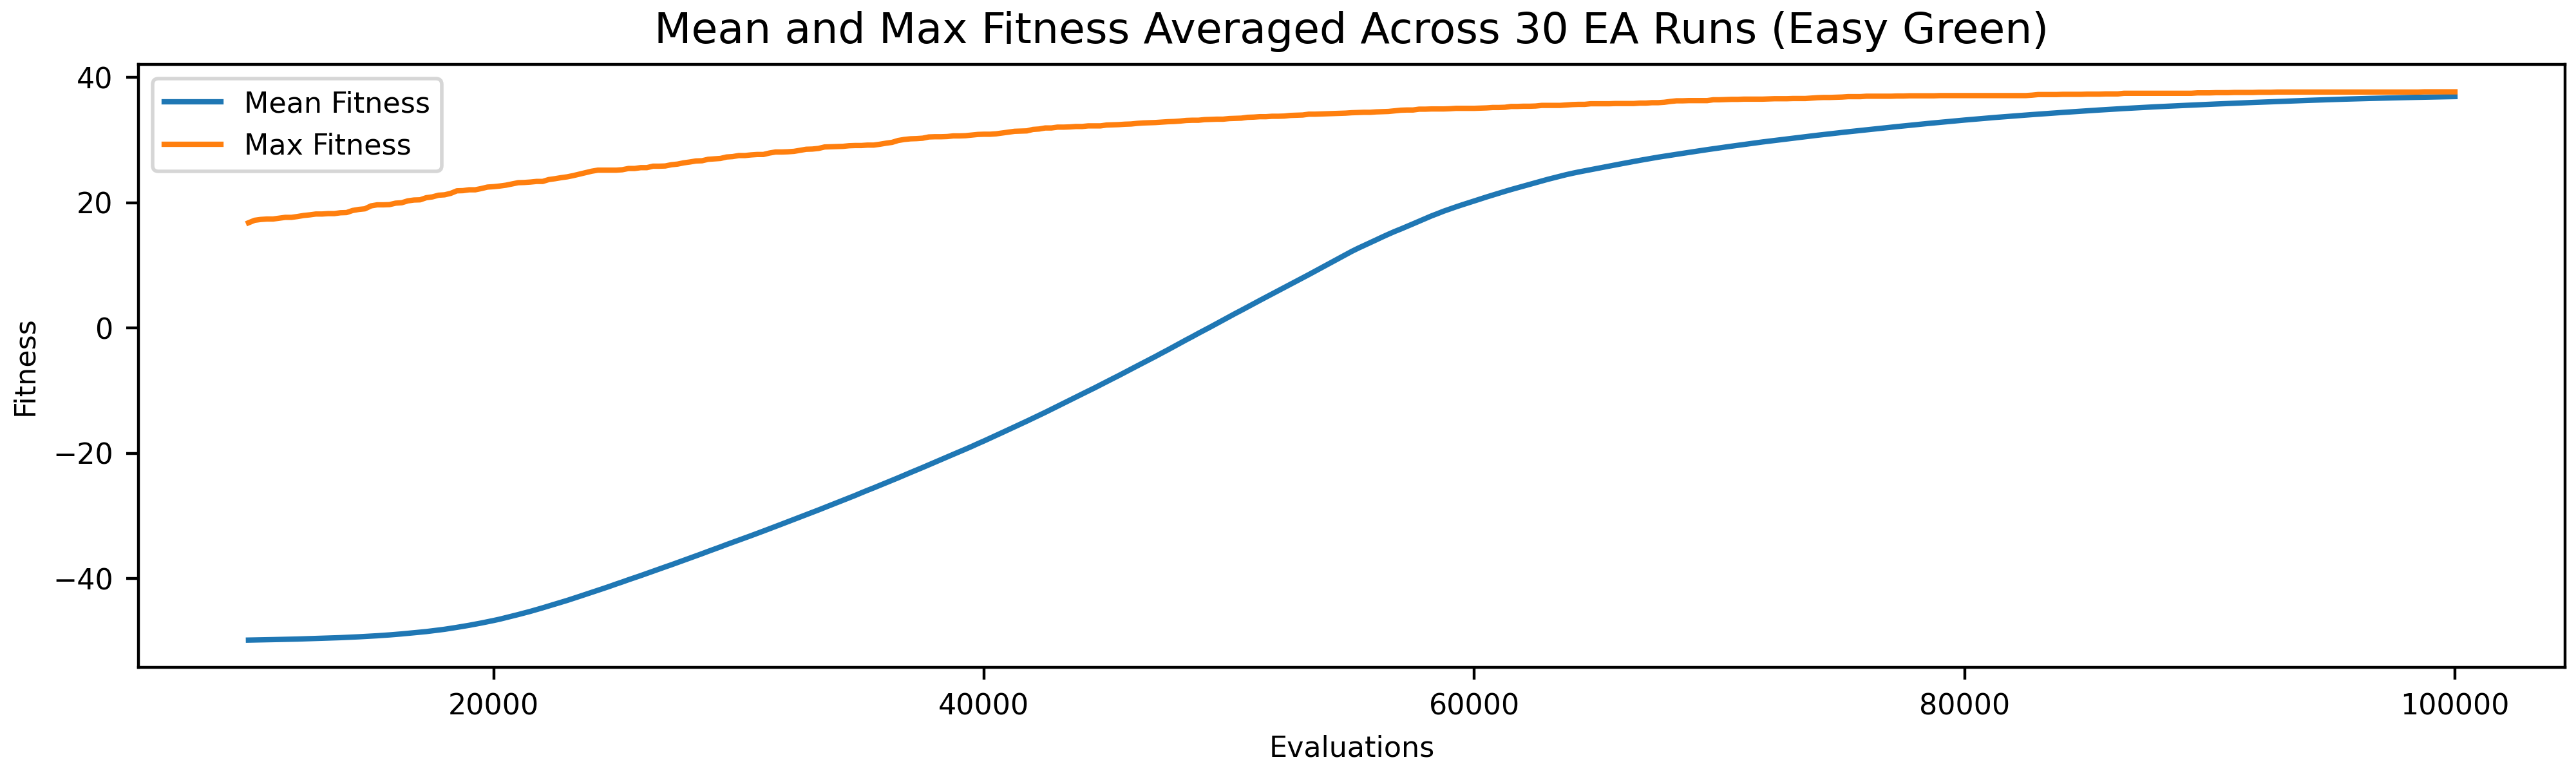

In the following cell, finish implementing the function to generate this plot:

In [ ]:
def evals_vs_fitness(mean_per_gen_per_run, max_per_gen_per_run, evaluation_counts, title, filename):
    # Using the input mean_per_gen_per_run and max_per_gen_per_run values,
    # store the y-values for mean fitness in average_means,
    # and the y-values for best fitness in average_maxes.
    average_means = None
    average_maxes = None

    
    
    # This will make the plot for you
    with plt.ioff():
        fig, ax = plt.subplots()
        ax.plot(evaluation_counts, average_means)
        ax.plot(evaluation_counts, average_maxes)
        ax.set(xlabel='Evaluations', ylabel='Fitness', title=title)
        ax.legend(['Mean Fitness', 'Max Fitness'])
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
        fig.savefig(filename)
        fig.show()

With that function completed, run the following cell to generate your evals-vs-fitness plot. We'll save it to `data/1b/example/plot.png`, as well as display it. If you haven't modified the config, this plot may look a little strange; if the lines are both horizontal, that is completely fine. Still, you should double-check that the plot agrees with the data that you collected.

In [ ]:
evals_vs_fitness(example_mean_per_gen_per_run,
                 example_max_per_gen_per_run,
                 example_evaluation_counts,
                 'Mean and Max Fitness Averaged Across a 3-run Experiment',
                 'data/1b/example/plot.png')

Since we will be running many different experiments, we will define one more function to reduce boilerplate. This function encapsulates both running an experiment and saving all the necessary data.

In [ ]:
def experiment_and_save(num_runs, num_evaluations, config, data_dir, problem_name):
    (
        best_per_run,
        best_solution,
        mean_per_gen_per_run,
        max_per_gen_per_run,
        evaluation_counts,
        hist,
        logs
    ) = evolutionary_algorithm_experiment(num_runs,
                                          num_evaluations,
                                          config)
    
    save_data(best_per_run,
              best_solution,
              mean_per_gen_per_run,
              max_per_gen_per_run,
              evaluation_counts,
              hist,
              logs,
              data_dir,
              config)

    visualize(best_solution.genes, **config['problem'])
    
    fig = hist.get_plot(f'Distribution of Fitnesses Over {num_runs} EA Runs ({problem_name})')
    fig.savefig(data_dir / 'histogram.png')
    fig.show()
    
    evals_vs_fitness(mean_per_gen_per_run,
                     max_per_gen_per_run,
                     evaluation_counts,
                     f'Mean and Max Fitness Averaged Across {num_runs} EA Runs ({problem_name})',
                     data_dir / 'plot.png')

### Tuning Your EA
Parameter tuning is an important part of using an EA in practice, and we have intentionally filled the config with several values that are either disastrous to performance, cause undesired behavior, or are simply invalid. Except for the problem-instance-specific parameters (ones we've left comments telling you to not touch), **you are expected to examine every configured value, think critically about what its impact on your EA is, and (if necessary) change it to a more sensible value. Part of your grade depends on improving these values before you conduct your experiment.**

Parameter tuning (and doing so fairly) is an entire problem within itself that you could devote tremendous amounts of time to. For this assignment though, we just ask that you informally tune your EA such that it consistently outperforms random search, though we encourage you to tune the parameters to the best of your ability. For informal hand-tuning, it's common to perform some small number of runs (let's say around 5) for each configuration in order to estimate its (stochastic) performance. Repeat this process with different parameters a few times and try to find reasonable values, but don't spend an exorbitant amount of time here.

Note that the artifacts your experiment generates (the histogram and evals-vs-fitness plots) are very useful for diagnosing poor configurations. For example, your histogram should be clearly different from the histogram you produced in Assignment 1a. We leave it up to you to determine how best to go about tuning using the available data, but remember that your ultimate goal is to maximize the average fitness of the best solution from each run (that is, the average of your experiment's `best_per_run`).

The following cell defines a function that will run an experiment and generate these artifacts for you to analyze. It will also save a copy of the config you used, which is an important part of the tuning process.

In [ ]:
def tuning_experiment(num_runs, num_evaluations, config_path, problem_name):
    config = read_config(config_path, globals(), locals())
    config_text = config_path.read_text()

    # Set up a new subdirectory for us to save artifacts to
    base_subdir = Path('./tuning/') / config_path.parent.name / config_path.stem
    base_subdir.mkdir(parents=True, exist_ok=True)
    children = set(int(child.stem) for child in base_subdir.iterdir())
    if children:
        index = max(children) + 1
    else:
        index = 1
    subdir = base_subdir / str(index)

    # Run your EA experiment and save the data
    experiment_and_save(num_runs, num_evaluations, config, subdir, problem_name)

    # Make a copy of the config
    config_copy = subdir / config_path.name
    config_copy.write_text(config_path.read_text())

    # Print average best fitness
    with open(subdir / 'best_per_run.txt', 'r') as f:
        best_per_run = [int(line) for line in f.readlines()]
    print('Average best fitness:', statistics.mean(best_per_run))

Before tuning, however, we have a few questions for you to think about:

**Question 1** (2%): Explain why it is important to conduct several independent runs of your EA to properly evaluate each parameter configuration.

Answer Question 1 here (double-click to edit)

**Question 2** (3%): The number of generations in one run of an EA can be calculated using only `num_evaluations`, `mu` ($\mu$), and `num_children` (aka lambda / $\lambda$). In the following cell, write either a math equation or Python-style pseudocode to perform this calculation.

Answer Question 2 here (double-click to edit)

**NOTE: Questions 3 through 10 are asking about the easy problem instance, NOT the hard problem instance.**

**Question 3** (0.5%): On the easy problem instance, what proportion of randomly-generated solutions are valid? State your answer as a decimal with at least five significant figures. As a reminder, we asked you to calculate this in Assignment 1a.

Answer Question 3 here (double-click to edit)

**Question 4** (1%): We can use your answer to Question 3 to calculate the [expected value](https://en.wikipedia.org/wiki/Expected_value) for the number of valid solutions in a randomly-generated population of a given size. Express this expected value for your EA's initial population in terms of `mu`.

Answer Question 4 here (double-click to edit)

**Question 5** (0.5%): Using your answer to Question 4, how many valid solutions would you expect in your initial population if `mu` was set to `100`?

Answer Question 5 here (double-click to edit)

**Question 6** (2%): Using your answer to Question 5, explain why setting `mu` to `100` is a bad idea.

Answer Question 6 here (double-click to edit)

**Question 7** (0.5%): Using your answer to Question 4, how many valid solutions would you expect in your initial population if `mu` was set to `99,000`?

Answer Question 7 here (double-click to edit)

**Question 8** (0.5%): Using your answer to Question 7, what percentage of your EA's total evaluations (`100,000`) would be spent evaluating randomly-generated (i.e., not evolved) solutions if `mu` is `99,000`?

Answer Question 8 here (double-click to edit)

**Question 9** (2%): Using your answer to Question 8, explain why setting `mu` to `99,000` is a bad idea.

Answer Question 9 here (double-click to edit)

**Question 10** (1%): Using your answer to Question 4, what value of `mu` would you need for an expected value of 5 valid solutions in your initial population? Round to the nearest integer.

Answer Question 10 here (double-click to edit)

After answering the above questions, you hopefully now have a decent intuition about appropriate values for `mu` ($\mu$) on the easy problem instance. This will be very helpful in the tuning process, which you will now begin.

Use the following cell to informally tune your EA by changing the parameters in `configs/1b/easy_green_config.txt`. Be careful not to tune the problem-instance-specific parameters (which we've left comments saying not to touch!) as doing so fundamentally changes the problem in a way that invalidates the comparison of results. As a reminder, there are certain deliberately-poor values in the configs we have provided you with, and you *must* change these to more sensible values. You are expected to think critically about the impacts of each parameter on your algorithm, and not just mindlessly change values without understanding what you're doing.

Here are some things to consider while tuning:

* How many generations of evolution will occur based on $\mu$ and $\lambda$?
* Is premature convergence occuring (e.g., max fitness stops increasing at a mediocre value)?
* Is a loss of diversity preventing improvement (e.g., mean and best fitness converge to very similar values)?

Change the parameters in `configs/1b/easy_green_config.txt`, run the following cell, and analyze the results. Repeat this process a few times until you find a reasonable set of parameters. Note that the end of the output contains the average best fitness from each of the tuning runs, which is the value you are trying to maximize.

In [ ]:
tuning_runs = 5 # Note you can increase this with no time loss if you have more CPU cores
num_evaluations = 100_000
easy_green_config_path = Path('./configs/1b/easy_green_config.txt')

tuning_experiment(tuning_runs, num_evaluations, easy_green_config_path, 'Easy Green')

## Running Your EA
With your tuning complete, you can execute the following cell to run your full experiment!

In [ ]:
num_runs = 30
num_evaluations = 100_000
easy_green_config = read_config('configs/1b/easy_green_config.txt', globals(), locals())
easy_green_data_path = Path('./data/1b/easy_green/')

experiment_and_save(num_runs,
                    num_evaluations,
                    easy_green_config,
                    easy_green_data_path,
                    'Easy Green')

## Statistical Analysis
Statistical analysis should consist of a comparison between best per-run fitness values of your EA searches with the data you generated during your experiment in Assignment 1a. You should have already copied all your 1a data to this assignment's `data` subdirectory. If you have not done so, then copy it now, but make sure not to overwrite your data from your EA's runs! Then you can run the below cell and interpret the results as you did in the previous assignment. Recall that we specify $\alpha=0.05$ for these tests.

In [ ]:
run_stats('data/1a/easy/best_per_run.txt', 'data/1b/easy_green/best_per_run.txt')

## Hard Problem Instance
Now we will repeat all of the above on the hard problem instance. First, you will need to tune `configs/1b/hard_green_config.txt`. Again, you must tune your config sufficiently to beat your random search's performance by a statistically-significant amount. We recommend that you start with the same parameters you used on the easy problem instance, but **make sure to copy them carefully** so as not to overwrite the `[problem]` header that defines the problem instance. After you do that, answer the following questions before conducting your tuning in the following cell:

**NOTE: Questions 11 through 13 are asking about the hard problem instance, NOT the easy problem instance.**

**Question 11** (0.5%): On the hard problem instance, what proportion of random solutions are valid? State your answer as a decimal with at least five significant figures. As a reminder, we asked you to calculate this in Assignment 1a.

Answer Question 11 here (double-click to edit)

**Question 12** (0.5%): On the hard problem instance, what value of `mu` would you need for an expected value of 5 valid solutions in your initial population? Round to the nearest integer.

Answer Question 12 here (double-click to edit)

**Question 13** (1%): Compare your answer to Question 12 with your answer to Question 10. Do you think you should use a different value for `mu` on the hard problem instance than you did on the easy problem instance? If so, how should you change `mu` and why?

Answer Question 13 here (double-click to edit)

In [ ]:
tuning_runs = 5 # Note you can increase this with no time loss if you have more CPU cores
num_evaluations = 100_000
hard_green_config_path = Path('./configs/1b/hard_green_config.txt')

tuning_experiment(tuning_runs, num_evaluations, hard_green_config_path, 'Hard Green')

After you're finished tuning your parameters, you can run the following cell to conduct your full experiment and run statistical analysis.

In [ ]:
num_runs = 30
num_evaluations = 100_000
hard_green_config = read_config('configs/1b/hard_green_config.txt', globals(), locals())
hard_green_data_path = Path('./data/1b/hard_green/')

experiment_and_save(num_runs,
                    num_evaluations,
                    hard_green_config,
                    hard_green_data_path,
                    'Hard Green')

run_stats('data/1a/hard/best_per_run.txt', 'data/1b/hard_green/best_per_run.txt')

## Report
Congratulations on completing the green portion of this notebook! Now, you should prepare your report. Refer to the assignment document for more information on what we require in your report.

# Yellow Deliverable (Bonus for 5660 students, required for 6660 students)
If attempting the 1b yellow deliverable, perform your experiment and analysis on the easy problem instance below. You must do this on your own, though it should be very easy to use the previous code cell as an example. Thanks to the way things are structured, you only need to change a small handful of variables. Of course, make sure to actually implement Stochastic Universal Sampling before you run this experiment, and make sure your config actually utilizes it for parent selection!

In [ ]:
# Run your easy yellow experiment and analysis here


Now repeat your experiment and analysis on the hard problem instance:

In [ ]:
# Run your hard yellow experiment and analysis here


# Red Deliverable (Bonus)
If attempting the 1b red deliverable, perform your experiment and analysis on the easy problem instance below.

In [ ]:
# Run your easy red experiment and analysis here


Now repeat your experiment and analysis on the hard problem instance:

In [ ]:
# Run your hard red experiment and analysis here
